In [2]:
!poetry add scikit-learn
!poetry add seaborn

Using version ^1.3.1 for scikit-learn

Updating dependencies
Resolving dependencies... (6.0s)Resolving dependencies... (4.9s)

Package operations: 0 installs, 2 updates, 0 removals

  • Updating pillow (10.0.1 -> 10.1.0): Pending...
  • Updating pillow (10.0.1 -> 10.1.0): Downloading... 0%
  • Updating pillow (10.0.1 -> 10.1.0): Downloading... 10%
  • Updating pillow (10.0.1 -> 10.1.0): Downloading... 20%
  • Updating pillow (10.0.1 -> 10.1.0): Downloading... 30%
  • Updating pillow (10.0.1 -> 10.1.0): Downloading... 40%
  • Updating pillow (10.0.1 -> 10.1.0): Downloading... 50%
  • Updating pillow (10.0.1 -> 10.1.0): Downloading... 60%
  • Updating pillow (10.0.1 -> 10.1.0): Downloading... 70%
  • Updating pillow (10.0.1 -> 10.1.0): Downloading... 80%
  • Updating pillow (10.0.1 -> 10.1.0): Downloading... 90%
  • Updating pillow (10.0.1 -> 10.1.0): Downloading... 100%
  • Updating pillow (10.0.1 -> 10.1.0): Installing...
  • Updating pillow (10.0.1 -> 10.1.0)
  • Updating sklearn (0.0

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv("feature_frame.csv").drop(columns="people_ex_baby")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 26 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [5]:

#Filtering orders with more than 5 buys
df_sell_prod = df[df["outcome"]==1]

count_sell_products = df_sell_prod.groupby(df_sell_prod.order_id).count().reset_index()

order_list = count_sell_products.order_id[count_sell_products.variant_id>=5].to_list()

df_filter = df[df.order_id.isin(order_list)]


#Encoding categorical variables
df_work = df_filter.copy()
categorical_cols = ['product_type', 'vendor']
for col in categorical_cols:
    col_frequency = df_filter[col].value_counts() / len(df_filter)
    df_work[f"{col}_encoded"] = df_work[col].map(col_frequency).copy()


df_work.sort_values(["user_id", "order_id", "order_date"], inplace=True)


del df
del df_sell_prod
del df_filter

In [6]:
info_cols = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
label_col = 'outcome'

features_cols = [col for col in df_work.columns if col not in info_cols + [label_col]]

categorical_cols = ['product_type', 'vendor']
binary_cols = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
numerical_cols = [col for col in features_cols if col not in categorical_cols + binary_cols]

In [7]:
a = df_work[df_work["outcome"]==1].groupby(["order_id", "user_id"]).count().sort_values(by="variant_id").reset_index()

In [8]:
from sklearn.model_selection import train_test_split

unique_orders = df_work["order_id"].unique()

train_orders, test_orders = train_test_split(unique_orders, test_size=0.2, random_state=99)
test_orders, validation_orders = train_test_split(test_orders, test_size=0.5, random_state=99)


df_train = df_work[df_work["order_id"].isin(train_orders)]
df_test = df_work[df_work["order_id"].isin(test_orders)]
df_validation = df_work[df_work["order_id"].isin(validation_orders)]


/tmp/ipykernel_79615/124375693.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df.loc[lambda x: x.outcome == 0, col], label='train', ax=ax[i])
/tmp/ipykernel_79615/124375693.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df.loc[lambda x: x.outcome == 1, col], label='test', ax=ax[i])


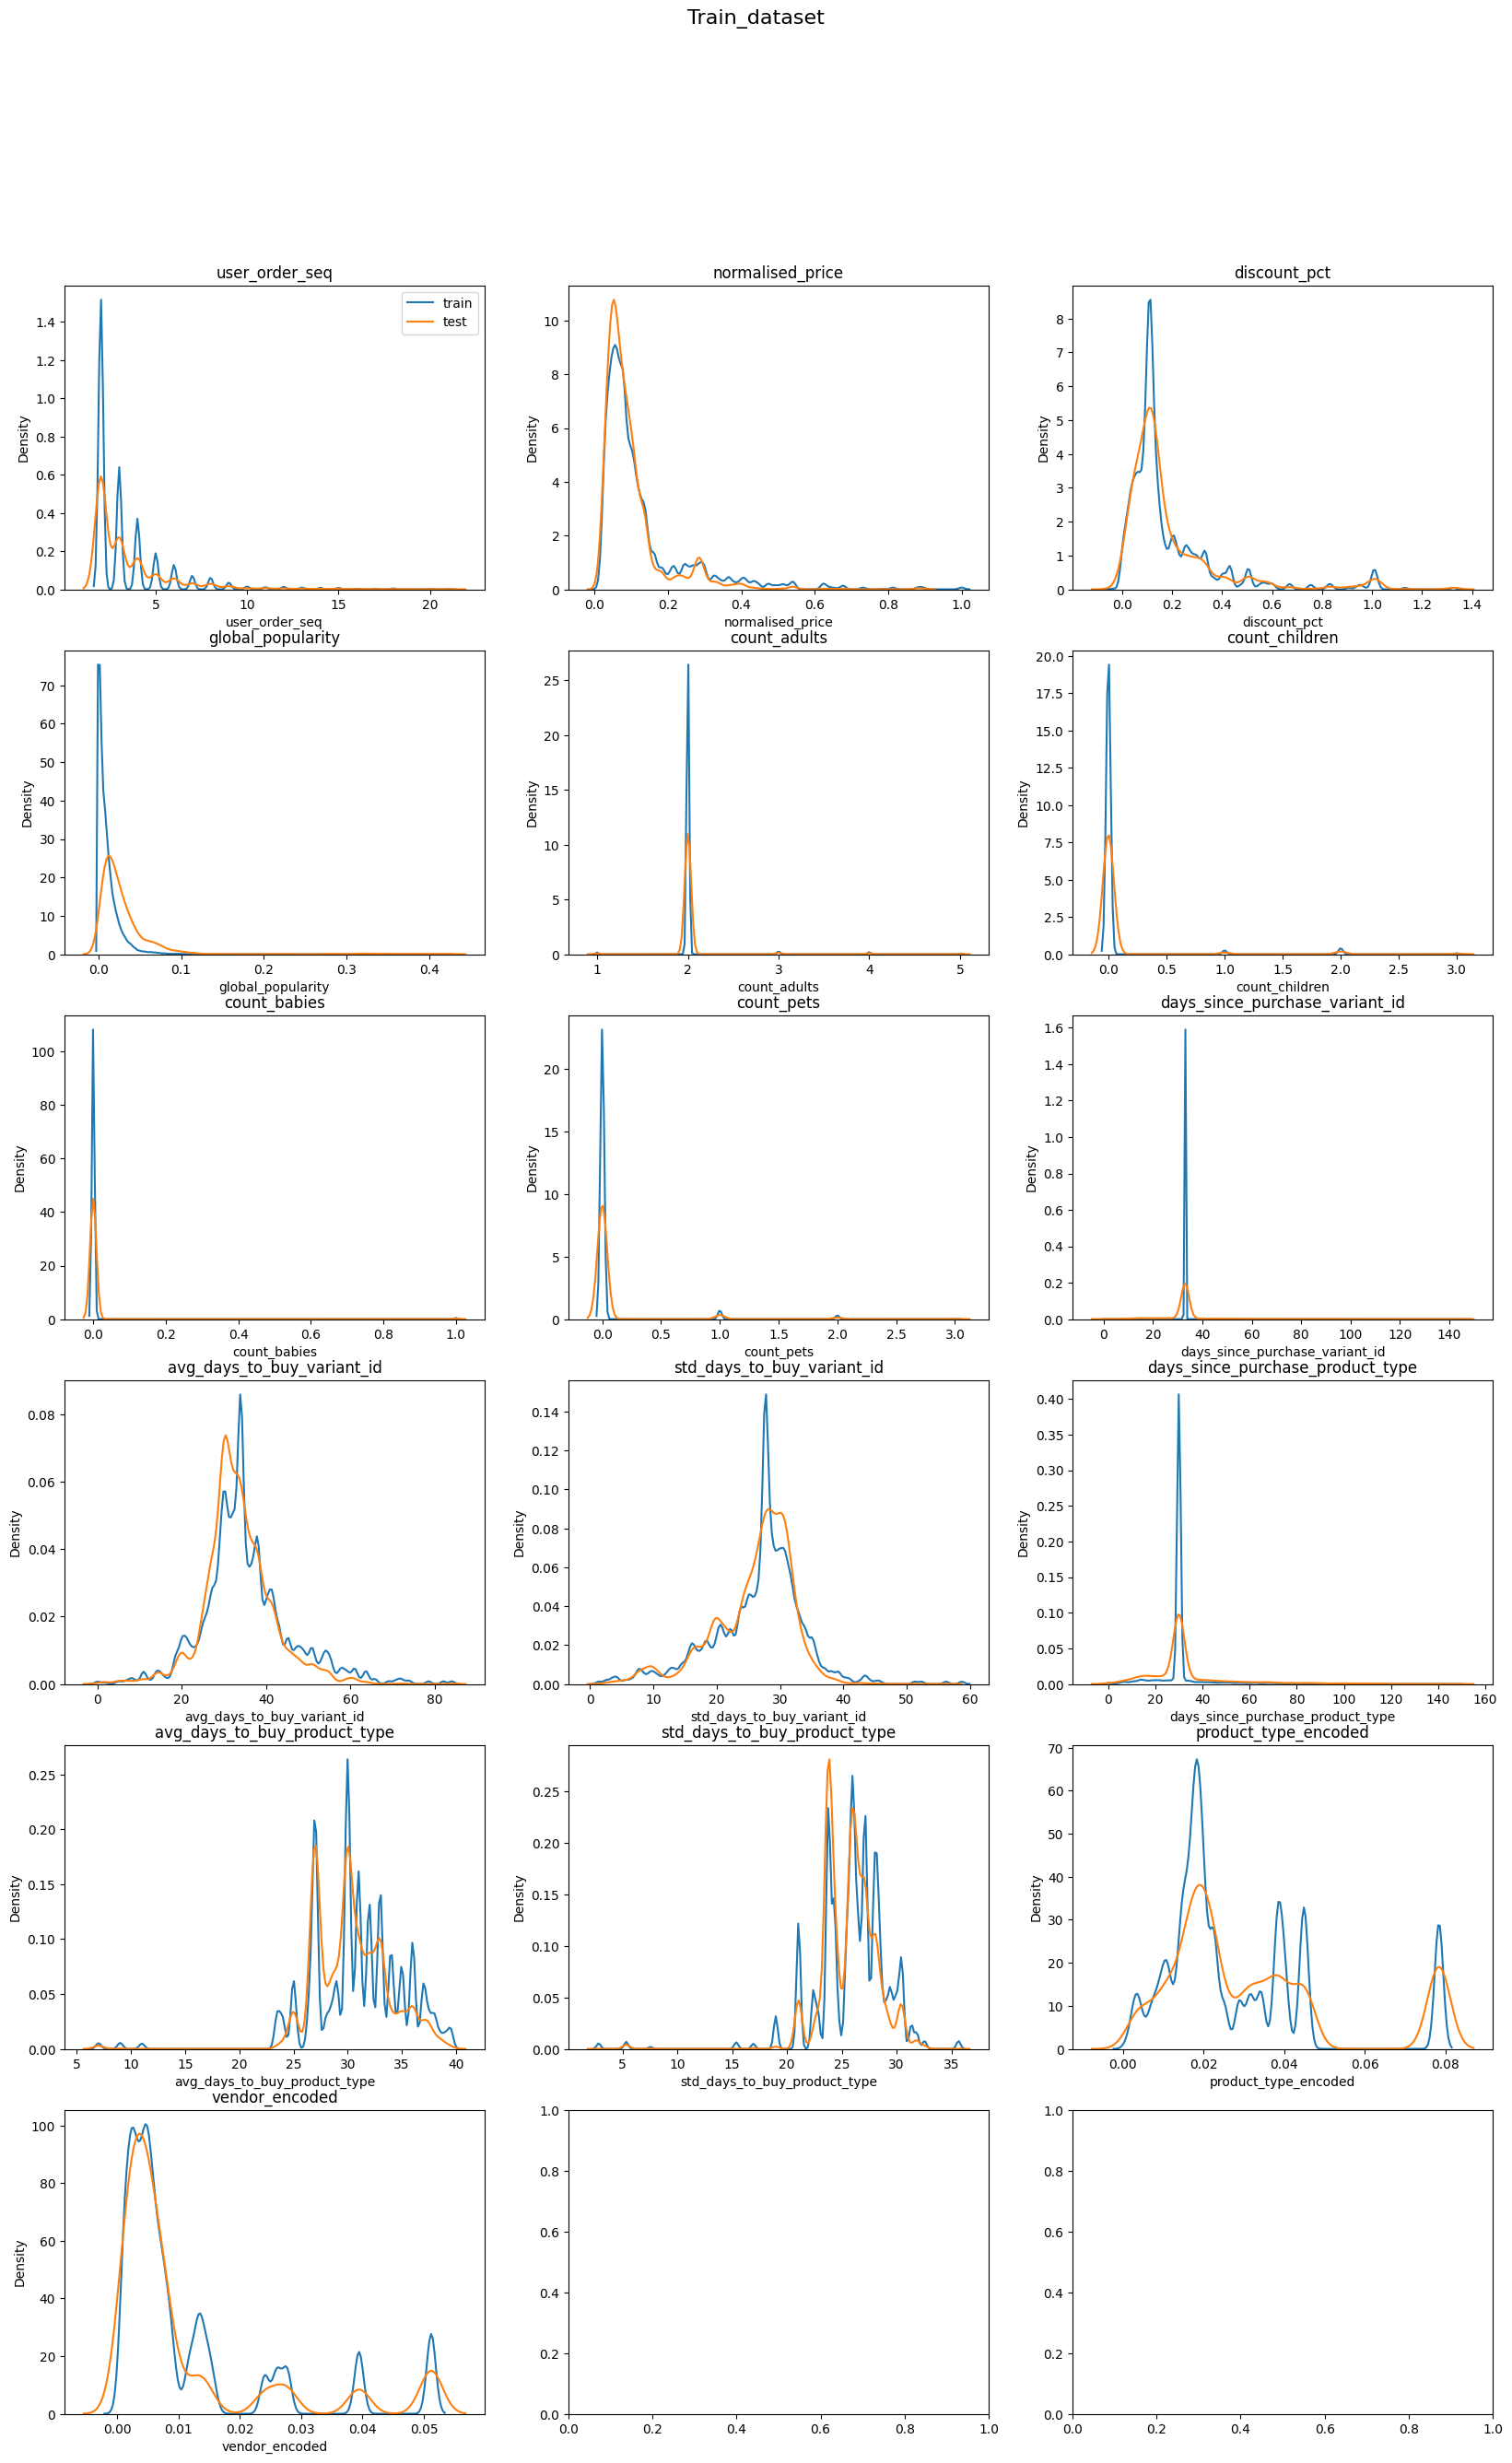

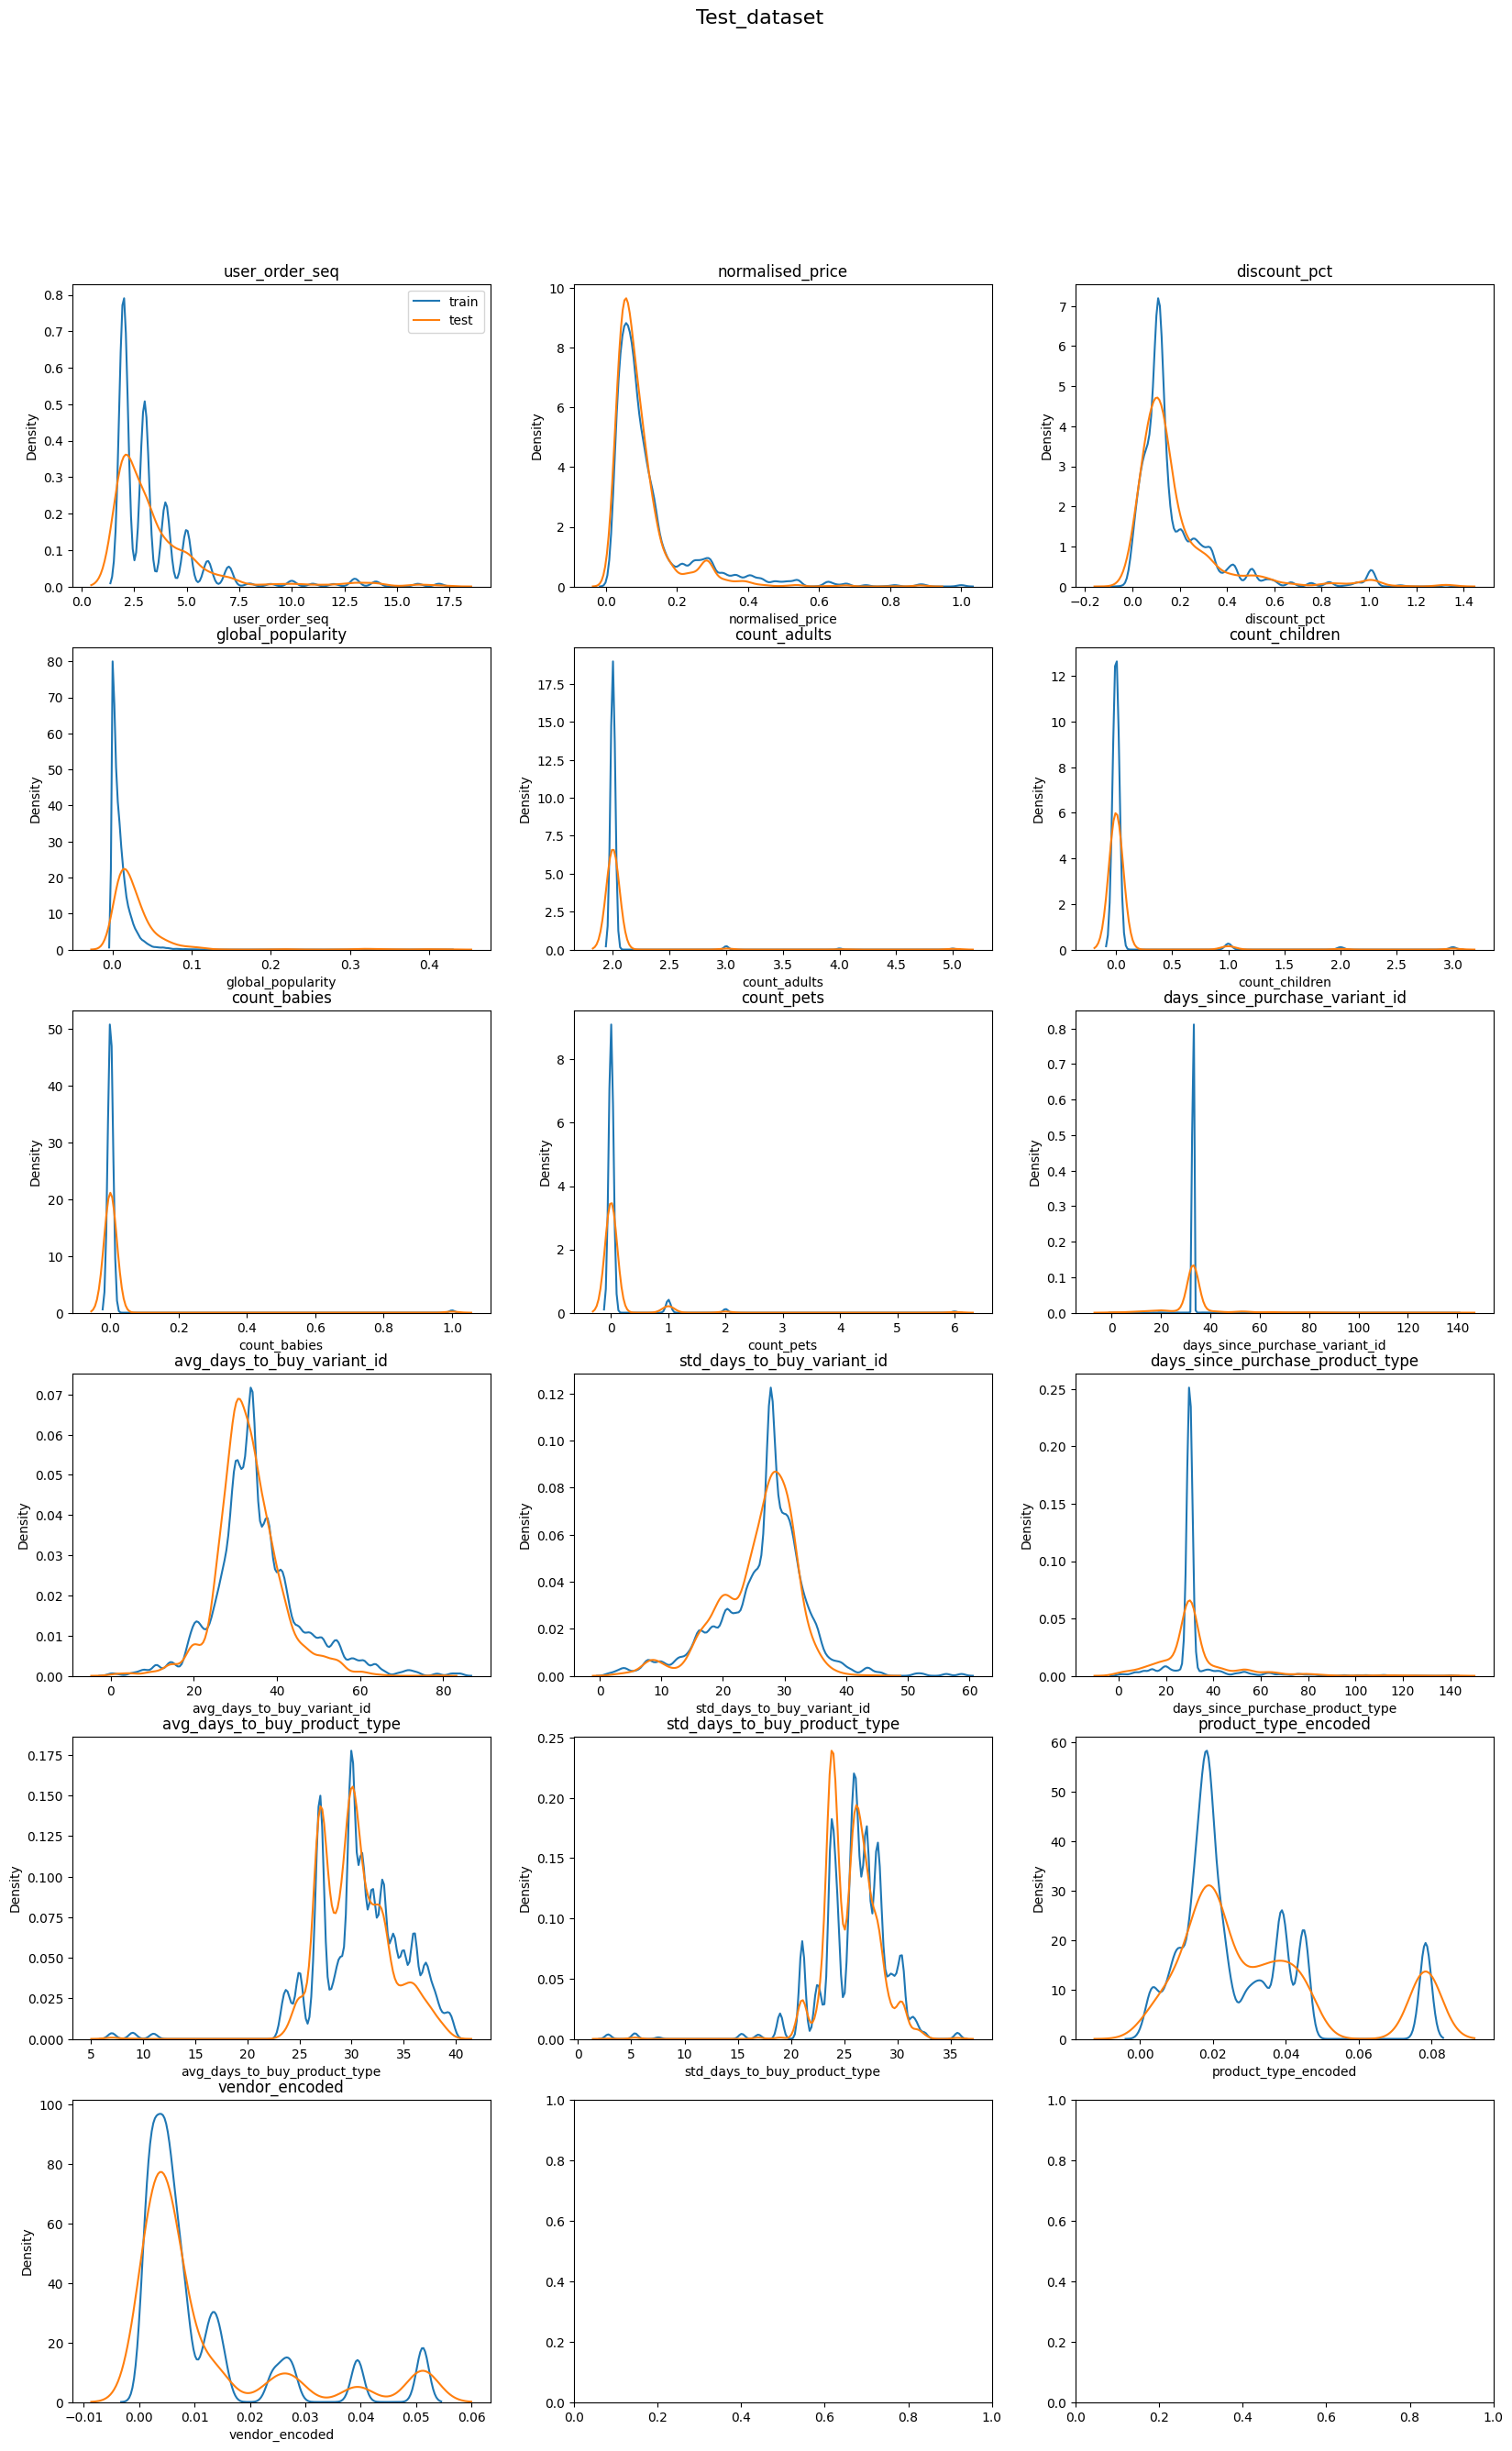

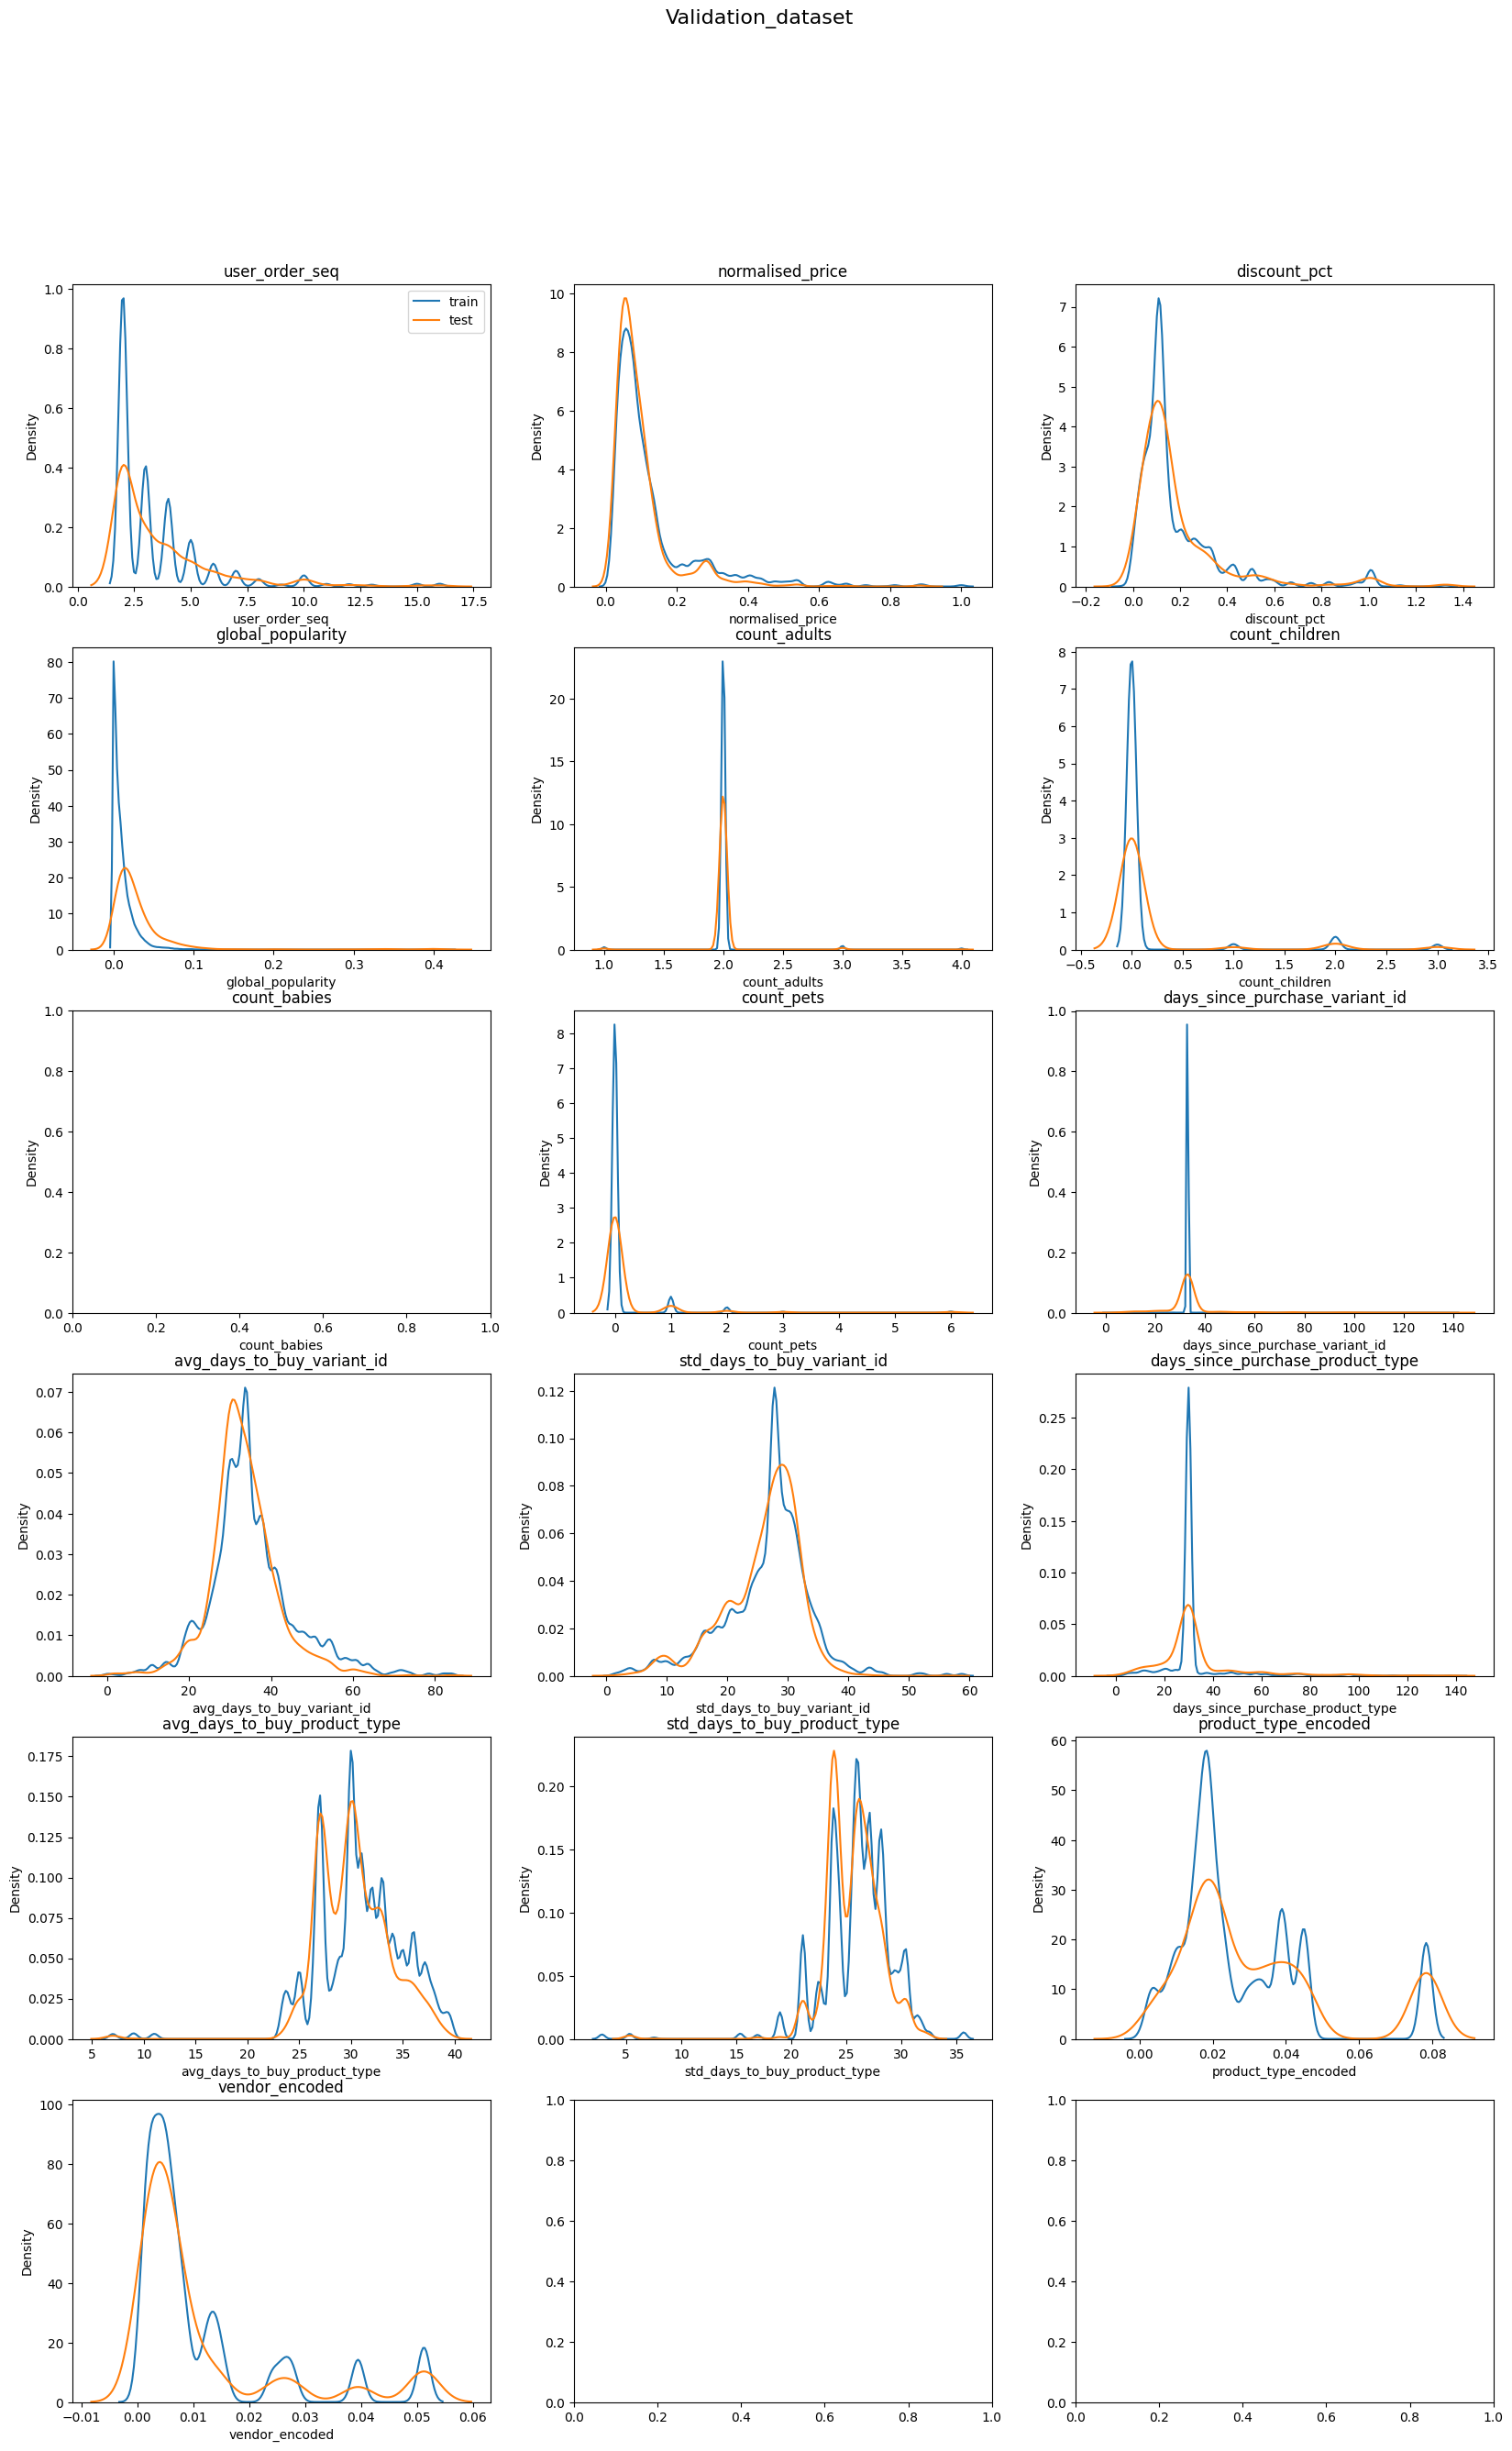

In [9]:

dfs = {"Train_dataset":df_train, "Test_dataset":df_test, "Validation_dataset":df_validation}

for main_title, df in dfs.items():
    cols = 3
    rows = int(np.ceil(len(numerical_cols) / cols))
    fig, ax = plt.subplots(rows, cols, figsize=(20, 5*rows))
    ax = ax.flatten()

    for i, col in enumerate(numerical_cols):
        sns.kdeplot(df.loc[lambda x: x.outcome == 0, col], label='train', ax=ax[i])
        sns.kdeplot(df.loc[lambda x: x.outcome == 1, col], label='test', ax=ax[i])
        ax[i].set_title(col)
        
    ax[0].legend()
    fig.suptitle(main_title, fontsize=16)

    # plt.tight_layout()

In [10]:
feature_cols = numerical_cols + binary_cols

X_train = df_train[feature_cols]
X_test = df_test[feature_cols]
X_validation = df_validation[feature_cols]

y_train, y_test, y_validation = df_train["outcome"], df_test["outcome"], df_validation["outcome"]

In [11]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)

model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

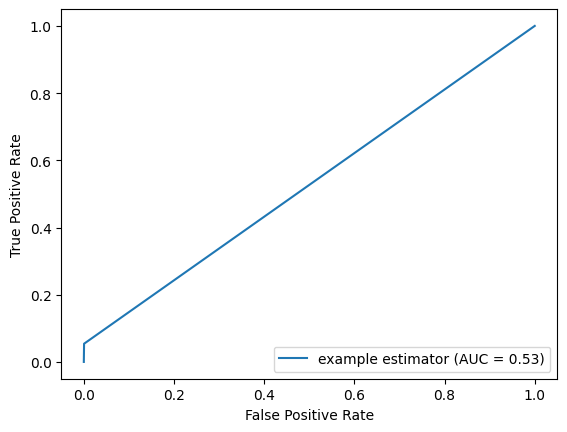

In [14]:
y_pred = model.predict(X_train)
from sklearn import metrics


fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                 estimator_name='example estimator')
display.plot()
plt.show()

In [ ]:
fpr

array([0.00000000e+00, 5.51510493e-04, 1.00000000e+00])

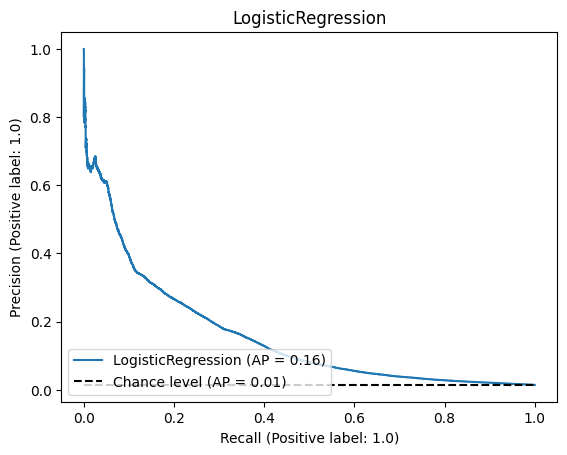

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    model, X_train, y_train, name="LogisticRegression", plot_chance_level=True
)
_ = display.ax_.set_title("LogisticRegression")

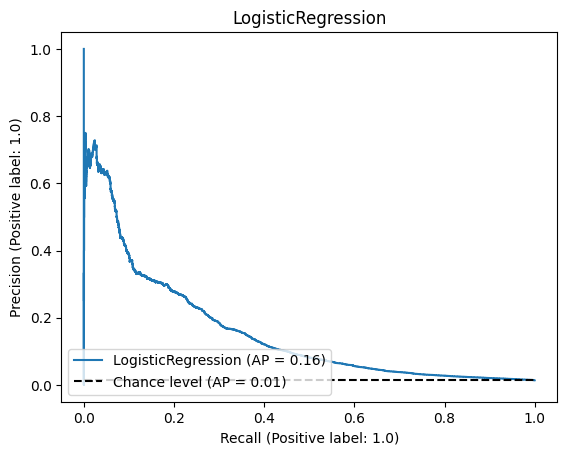

In [ ]:
display = PrecisionRecallDisplay.from_estimator(
    model, X_test, y_test, name="LogisticRegression", plot_chance_level=True
)
_ = display.ax_.set_title("LogisticRegression")

TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

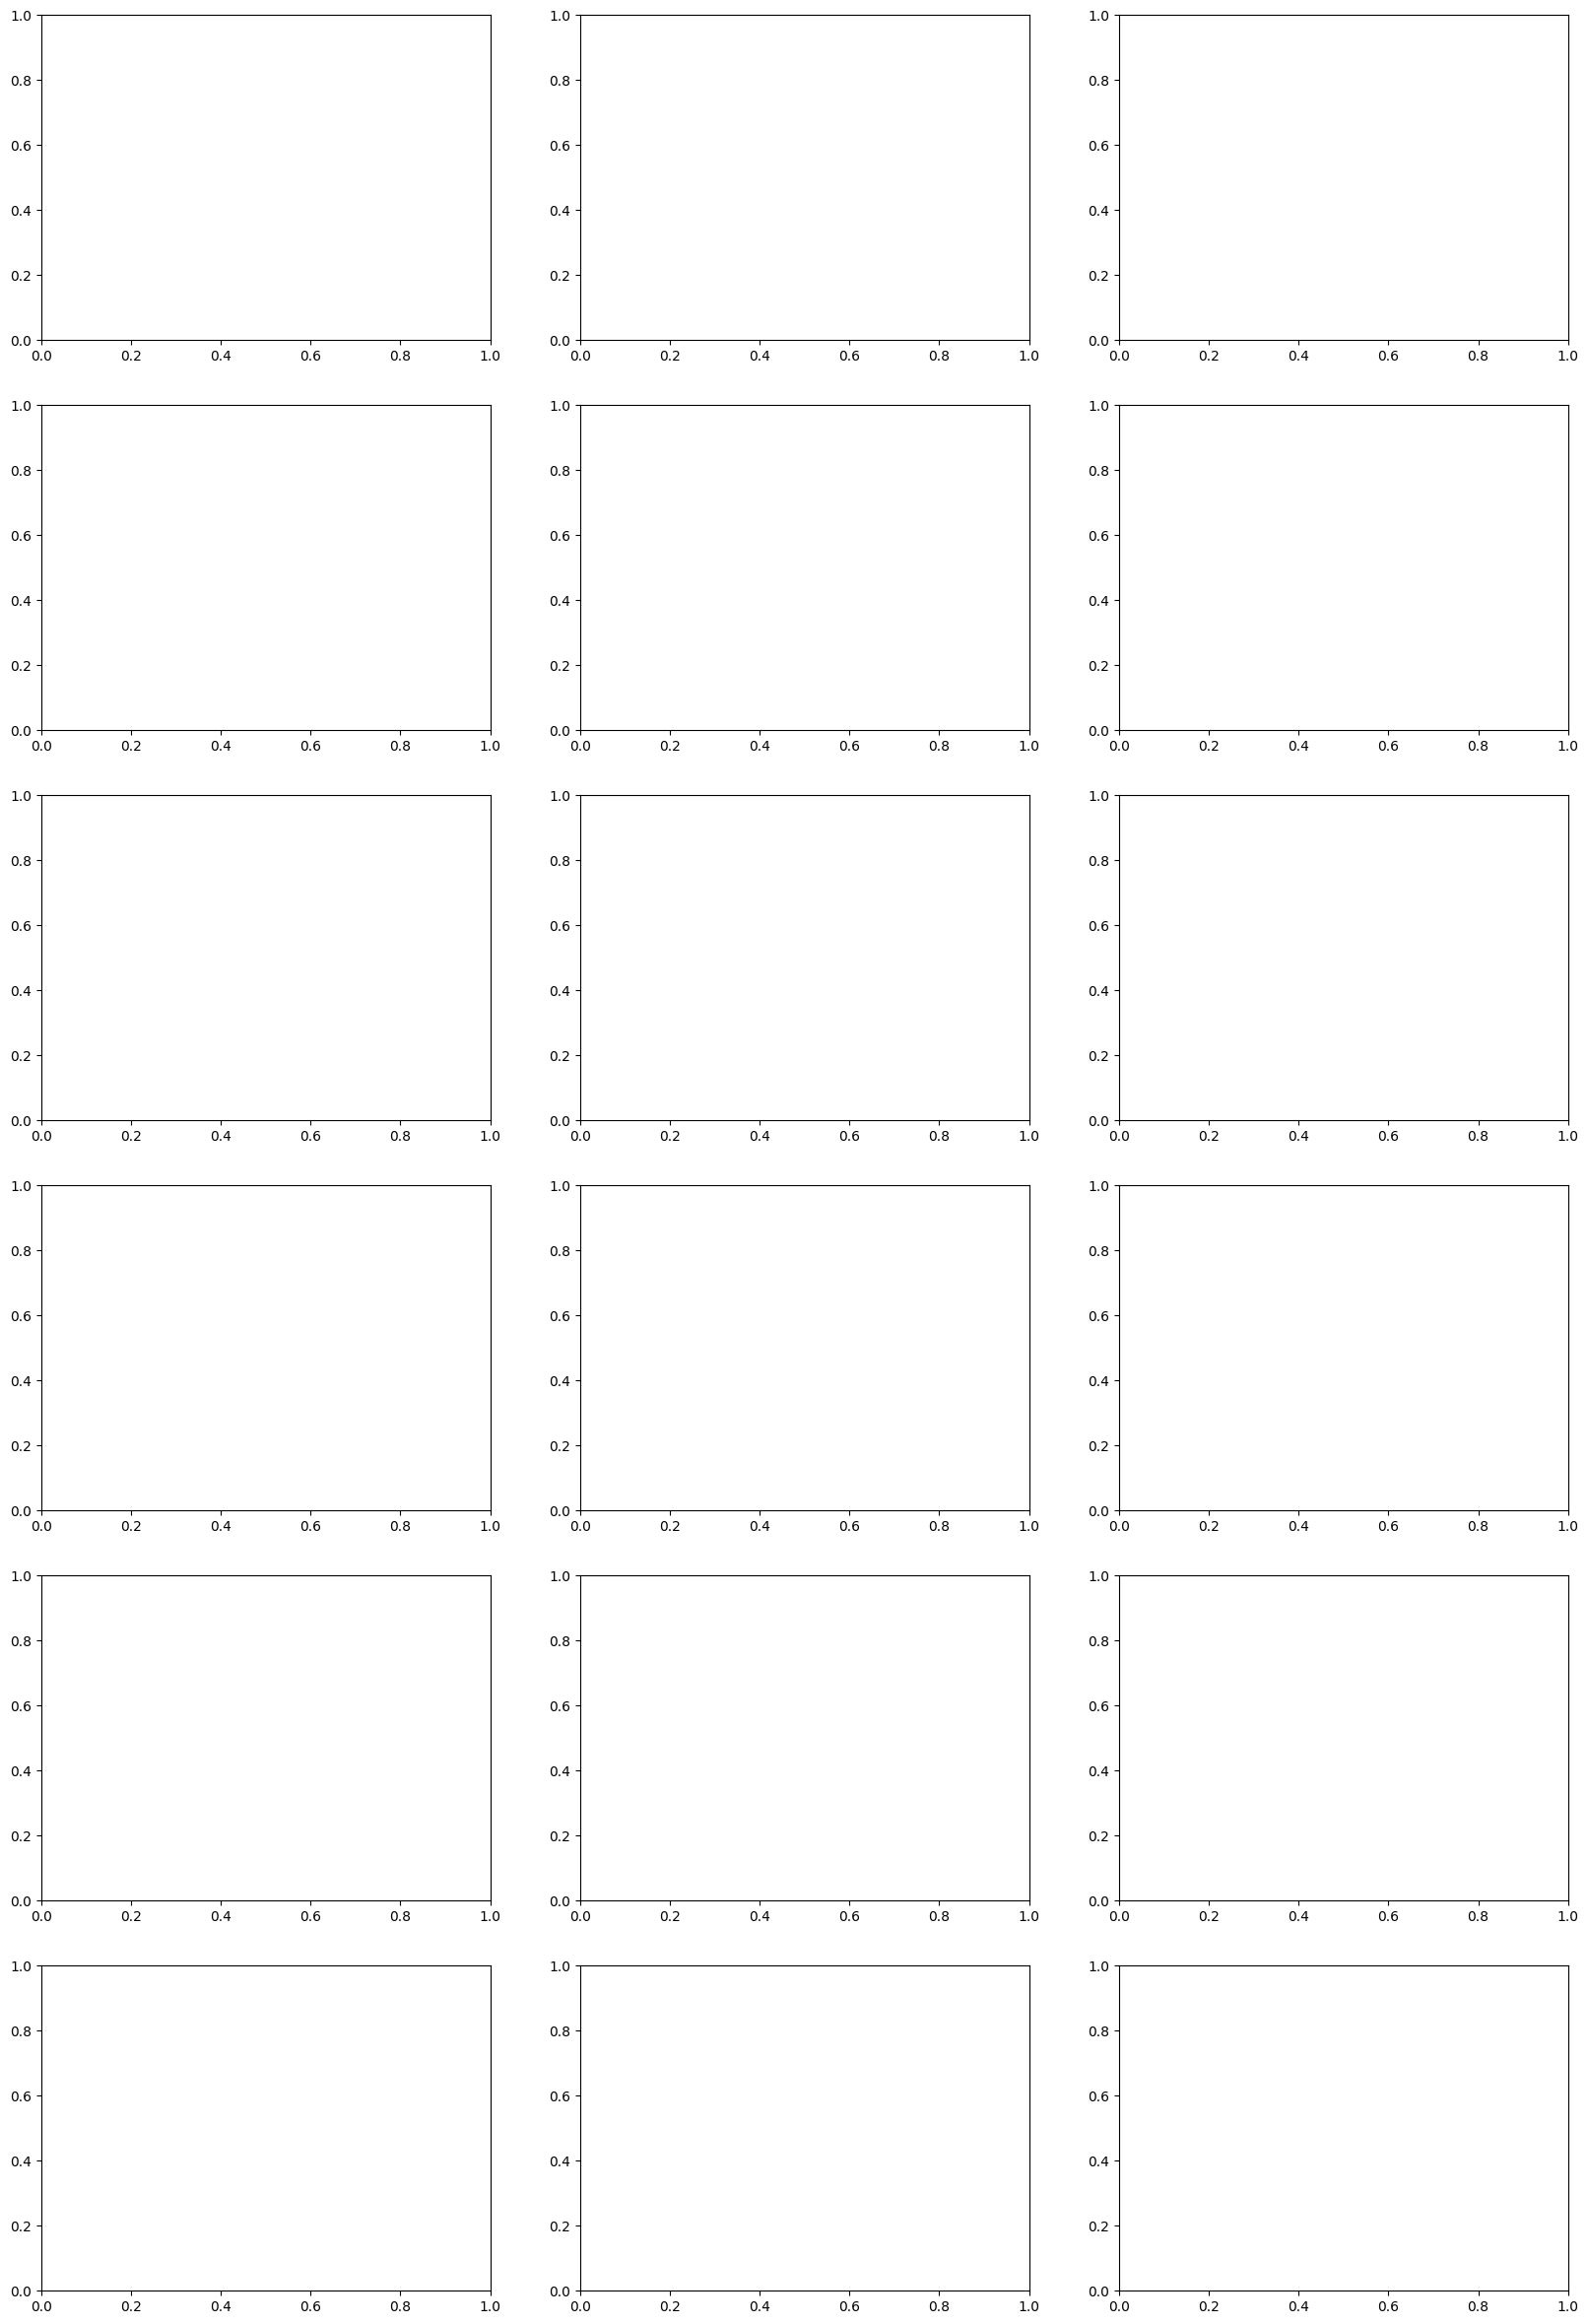

In [ ]:
cols = 3
rows = int(np.ceil(len(numerical_cols) / cols))
fig, ax = plt.subplots(rows, cols, figsize=(20, 5*rows))
ax = ax.flatten()

for i, col in enumerate(numerical_cols):
    sns.kdeplot(df_train.loc[lambda x: x.outcome == 0, col], label='0', ax=ax[i])
    sns.kdeplot(df_train.loc[lambda x: x.outcome == 1, col], label='1', ax=ax[i])
    ax[i].set_title(col)
    
ax[0].legend()

plt.tight_layout()

In [ ]:
df_test, df_validation = train_test_split(test, test_size=0.5, stratify=df_work.order_id)


ValueError: Found input variables with inconsistent numbers of samples: [432791, 2163953]

In [ ]:
train.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_babies,count_pets,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,product_type_encoded,vendor_encoded
239225,33826427502724,cookingingredientsoils,2869681127556,3820142788740,2020-12-11 09:45:23,2020-12-11 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,33.0,39.0,31.727619,32.0,31.0,27.135844,0.038385,0.051212
1552017,34460976414852,dental,2895188983940,3781485789316,2021-01-12 09:48:51,2021-01-12 00:00:00,5,0.0,0.0,0.0,...,0.0,0.0,33.0,29.0,12.733243,54.0,33.0,27.935275,0.022422,0.005585
1734022,33881379668100,shavinggrooming,2922904748164,3913643884676,2021-02-15 21:04:54,2021-02-15 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,33.0,48.0,30.701972,30.0,35.0,27.143111,0.015014,0.014737
2043873,33667174498436,handsoapsanitisers,2904720146564,3817296461956,2021-01-24 17:50:00,2021-01-24 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,33.0,36.0,23.924380,30.0,33.0,27.961179,0.020018,0.013232
729370,34543001927812,cleaningaccessories,3643226718340,3929955500164,2021-03-03 12:32:48,2021-03-03 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,33.0,34.0,27.693045,30.0,35.0,29.001400,0.017485,0.000464


In [ ]:
df_work[(df_work["count_adults"] + df_work["count_children"] ) !=  df_work["people_ex_baby"]].head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,product_type_encoded,vendor_encoded


In [ ]:
# df[df["order_id"]==2807985930372].to_csv("order_sample.txt", sep="\t")
# #df[df["user_id"]==3482464092292].to_csv("user sample.txt", sep="\t")
# # df[df["variant_id"]==33826472919172]

# # df = df.head(1000)
# df.info()

In [ ]:

df_work.head()


NameError: name 'df_work' is not defined

In [ ]:
len()

2795

In [ ]:
df_filter.sort_values(by="variant_i")

,order_id,variant_id,product_type,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,2807985930372,608,608,608,608,608,608,608,608,608,...,608,608,608,608,608,608,608,608,608,608
1,2808027644036,608,608,608,608,608,608,608,608,608,...,608,608,608,608,608,608,608,608,608,608
2,2808099078276,608,608,608,608,608,608,608,608,608,...,608,608,608,608,608,608,608,608,608,608
3,2808393957508,611,611,611,611,611,611,611,611,611,...,611,611,611,611,611,611,611,611,611,611
4,2808429314180,614,614,614,614,614,614,614,614,614,...,614,614,614,614,614,614,614,614,614,614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3422,3642900349060,976,976,976,976,976,976,976,976,976,...,976,976,976,976,976,976,976,976,976,976
3421,3642856079492,976,976,976,976,976,976,976,976,976,...,976,976,976,976,976,976,976,976,976,976
3444,3643294515332,976,976,976,976,976,976,976,976,976,...,976,976,976,976,976,976,976,976,976,976
3432,3643189461124,976,976,976,976,976,976,976,976,976,...,976,976,976,976,976,976,976,976,976,976
